In [1]:
%load_ext autoreload
%autoreload 2
import sys, os

In [16]:
import glob, os
import mediapy as media
import torch
from torch.utils.data import DataLoader

from load_model_from_ckpt import load_model, get_sampler, init_samples
from datasets import get_dataset, data_transform, inverse_data_transform
from runners.ncsn_runner import conditioning_fn

from os.path import expanduser
home = expanduser("~")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Set directories to download model, data

In [3]:
# SET THESE!!!
GDRIVE_URL = "https://drive.google.com/drive/folders/1bM6wqU_kymoljz5uYQRCYNup_8adBfLH" # smmnist_big_5c5_unetm_b2
EXP_PATH = os.path.join(home, "scratch/MCVD_SMMNIST_pred")
DATA_PATH = os.path.join(home, "scratch/Datasets/MNIST")

# Download experiment (model checkpoint, config, etc.)

In [4]:
GDRIVE_URL = GDRIVE_URL.removesuffix("?usp=sharing")
!gdown --fuzzy {GDRIVE_URL} -O {EXP_PATH}/ --folder

Retrieving folder list
Retrieving folder 1CzwozDKbsOH_V2099N9-HBeeMO4441iT logs
Processing file 14Di0OplaG_F-Ogmmv8w_K0NqYP5Bag9r args.yml
Processing file 1uTfMtTfTT5WMAdDR1x2WNrOQnldk__yA checkpoint_140000.pt
Processing file 1xOY4-oh7jSCSKqtDktvtTCt3CasNzT64 config.yml
Processing file 1zuqnoOOxfvBzjpgaFR77j8OGUUs808oj epochs.png
Processing file 1PMXh9CluffmccQO_llGmRMf6DRhXU9Db fvd_log.png
Processing file 1BWgT0O20aaa-TtsKezIB1UxMzNkL0HOH fvd.png
Processing file 1DWk2o8zyj4h9lfaZcLbUxln4ZiV7z04v grad_log.png
Processing file 10iH96rRLPlHPRaZHuS7SNdYg0KjOlah6 grad.png
Processing file 1Eebka2ybBXoYXBGOdom1059LEl2wyC-f loss_log.png
Processing file 1SmtLNaMHHUV4L6SXGV_QacQ7augGQBC3 loss.png
Processing file 1hQo6pWh3pIHteyVx90_YzsDg9Z-BKSHm lpips_log.png
Processing file 1I2sme46c9twlixOYkThZxcIh8ptpzBZz lpips.png
Processing file 1B_LvuvnNmmNKqacX2NLx4_-_0o6dniuZ lr.png
Processing file 1v6i8iwed7QDw84LKpsl9jpoAQZ-UZ410 meters.pkl
Processing file 1cmaGJZ3El7xe91JvJkt4QpA00HYwnATA mse_log.png


# Load model checkpoint

In [5]:
ckpt_path = glob.glob(os.path.join(EXP_PATH, "checkpoint_*.pt"))[0]
scorenet, config = load_model(ckpt_path, device)
sampler = get_sampler(config)

In [21]:
print(device)
print(ckpt_path)
print(config)

cuda
/home/mila/v/voletivi/scratch/MCVD_SMMNIST_pred/checkpoint_140000.pt
Namespace(data=Namespace(channels=1, dataset='StochasticMovingMNIST', gaussian_dequantization=False, image_size=64, logit_transform=False, num_digits=2, num_frames=5, num_frames_cond=5, num_workers=0, prob_mask_cond=0.0, random_flip=True, rescaled=True, step_length=0.1, uniform_dequantization=False), fast_fid=Namespace(batch_size=1000, begin_ckpt=5000, end_ckpt=300000, ensemble=False, freq=5000, n_steps_each=0, num_samples=1000, pr_nn_k=3, step_lr=0.0, verbose=False), model=Namespace(arch='unetmore', attn_resolutions=[8, 16, 32], ch_mult=[1, 2, 3, 4], cond_emb=False, conditional=True, depth='deep', dropout=0.1, ema=True, ema_rate=0.999, gamma=False, gff=False, n_head_channels=64, ngf=64, noise_in_cond=False, nonlinearity='swish', normalization='InstanceNorm++', num_classes=1000, num_res_blocks=2, output_all_frames=False, sigma_begin=0.02, sigma_dist='linear', sigma_end=0.0001, spade=True, spec_norm=False, time_co

# Load data

In [8]:
dataset, test_dataset = get_dataset(DATA_PATH, config, video_frames_pred=config.data.num_frames)

Dataset length: 60000
Dataset length: 256


In [9]:
# dataloader = DataLoader(dataset, batch_size=config.training.batch_size, shuffle=True,
#                         num_workers=config.data.num_workers)
# train_iter = iter(dataloader)
# x, y = next(train_iter)

test_loader = DataLoader(test_dataset, batch_size=config.training.batch_size, shuffle=False,
                         num_workers=config.data.num_workers, drop_last=True)
test_iter = iter(test_loader)
test_x, test_y = next(test_iter)
print(test_x.shape)

torch.Size([64, 10, 1, 64, 64])


In [10]:
test_x = data_transform(config, test_x)
real, cond, cond_mask = conditioning_fn(config, test_x, num_frames_pred=config.data.num_frames,
                                        prob_mask_cond=getattr(config.data, 'prob_mask_cond', 0.0),
                                        prob_mask_future=getattr(config.data, 'prob_mask_future', 0.0))
print(real.shape, cond.shape)

torch.Size([64, 5, 64, 64]) torch.Size([64, 5, 64, 64])


,,,,,,,,,

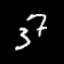
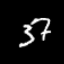
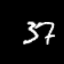
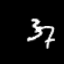
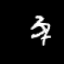
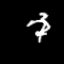
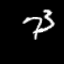
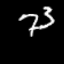
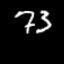
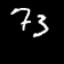

In [11]:
i = 1
# media.show_images(torch.cat([cond[i].permute(0, 2, 3, 1), real[i].permute(0, 2, 3, 1)]))
media.show_images(torch.cat([cond[i], real[i]]))

# Load initial samples

In [12]:
init = init_samples(len(real), config)

torch.Size([64, 5, 64, 64])


,,,,

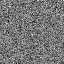
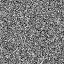
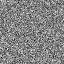
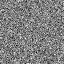
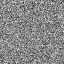

In [13]:
print(init.shape)
media.show_images(init[i])

# Predict

In [18]:
pred = sampler(init, scorenet, cond=cond, cond_mask=cond_mask, subsample=100, verbose=True)

DDPM: 1/100, grad_norm: 143.2518768310547, image_norm: 129.60122680664062, grad_mean_norm: 325.6442565917969
DDPM: 10/100, grad_norm: 143.25779724121094, image_norm: 130.69338989257812, grad_mean_norm: 320.6053466796875
DDPM: 20/100, grad_norm: 143.30130004882812, image_norm: 131.94703674316406, grad_mean_norm: 321.99261474609375
DDPM: 30/100, grad_norm: 143.56088256835938, image_norm: 133.11929321289062, grad_mean_norm: 321.1786193847656
DDPM: 40/100, grad_norm: 144.76840209960938, image_norm: 134.29885864257812, grad_mean_norm: 322.8674621582031
DDPM: 50/100, grad_norm: 148.45303344726562, image_norm: 135.35610961914062, grad_mean_norm: 322.8923034667969
DDPM: 60/100, grad_norm: 157.97732543945312, image_norm: 136.23965454101562, grad_mean_norm: 325.763916015625
DDPM: 70/100, grad_norm: 180.5244903564453, image_norm: 136.7104034423828, grad_mean_norm: 320.1344299316406
DDPM: 80/100, grad_norm: 235.61495971679688, image_norm: 137.1285400390625, grad_mean_norm: 319.7248229980469
DDPM: 

torch.Size([64, 5, 64, 64])


,,,,,,,,,

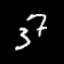
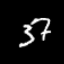
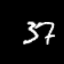
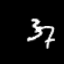
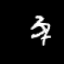
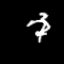
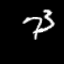
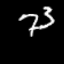
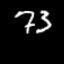
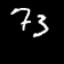

,,,,,,,,,

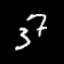
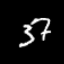
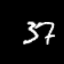
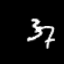
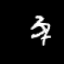
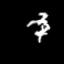
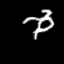
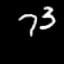
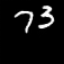
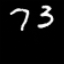

In [22]:
print(pred.shape)
i = 1
media.show_images(torch.cat([cond[i], real[i]]))
media.show_images(torch.cat([cond[i], pred[i]]))

,,,,,,,,,

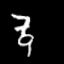
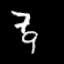
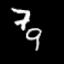
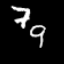
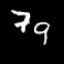
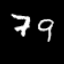
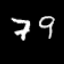
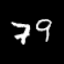
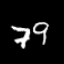
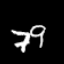

,,,,,,,,,

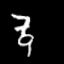
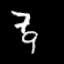
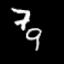
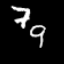
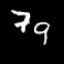
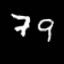
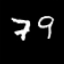
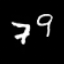
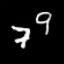
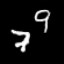

In [26]:
i = 4
media.show_images(torch.cat([cond[i], real[i]]))
media.show_images(torch.cat([cond[i], pred[i]]))